In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import os
import tqdm
from collections import namedtuple

In [37]:
import glob, time

## Functions

In [4]:
def histoplot(var, xlabel, ylabel, bins=100, figsize=(4,4), title=""):
    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    h = plt.hist(var,bins)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    return h[0],h[1]

In [5]:
def prgroup(grdf, ng=1):
    i = 1
    for name, group in grdf:
        print(f"Group: {name}")
        print(group, "\n")
        i+=1
        if i > ng:
            break

In [6]:
def event_ekin(df):
    grdf = df.groupby('event_id')
    ekin = grdf['kin_energy'].sum()
    return ekin

In [7]:
def event_size(df):
    return len(np.unique(df.event_id))

In [32]:
def xindex(x,mcrst, sx):
    return np.floor((x + mcrst.xmin + mcrst.dx)/sx)

def yindex(x,mcrst, sy):
    return np.floor((x + mcrst.ymin + mcrst.dy)/sy)

def zindex(x,mcrst, sz):
    return np.floor((x - mcrst.zmin)/sz)


In [36]:
def voxelize(gdfx,mcrst,sx,sy,sz,case='pixel'):
    gdf = gdfx.copy()
    nx = int(mcrst.dx/sx)
    ny = int(mcrst.dy/sy)
    nz = int(mcrst.dz/sz)
    
    print(f"nx = {nx}, ny = {ny}, nz = {nz}")
    print(f"number of voxels = {nx*ny*nz}")
    print(f"index for xmin ={xindex(mcrst.xmin, mcrst, sx)} index for xmax ={xindex(mcrst.xmax, mcrst, sx)}")
    print(f"index for ymin ={yindex(mcrst.ymin, mcrst, sy)} index for ymax ={yindex(mcrst.ymax, mcrst, sy)}")
    print(f"index for zmin ={zindex(mcrst.zmin, mcrst, sz)} index for zmax ={zindex(mcrst.zmax, mcrst, sz)}")

    gdf["ix"]= xindex(gdf.final_x.values, mcrst, sx).astype(int)
    gdf["iy"]= yindex(gdf.final_y.values, mcrst, sy).astype(int)
    gdf["iz"]= zindex(gdf.final_z.values, mcrst, sz).astype(int)

    if case == 'pixel':
        grdf = gdf.groupby(['event_id', 'ix', 'iy'])
    else:
         grdf = gdf.groupby(['event_id', 'ix', 'iy', 'iz'])

    gdf = grdf.agg(
                ebox = ('kin_energy', 'sum'),
                tbox = ('initial_t', 'mean'),     
                xbox = ('final_x', 'mean'),     
                ybox = ('final_y', 'mean'),        
                zbox = ('final_z', 'mean'),        # z in the box is the y mean
                nbox = ('final_z', 'count'),
                  ).reset_index()
    
    return gdf

In [10]:
def pixelated(gdfx,mcrst,sx,sy,sz, ecut, case='pixel'):
    gdf = voxelize(gdfx,mcrst,sx,sy,sz, ecut)
    gdf =gdf[gdf.ebox >ecut]
    return event_size(gdf)

In [11]:
def streams(gdx):
    gdf  = gdx.copy()
    grdf = gdf.groupby('event_id')
    gdf  = grdf.agg(#event_id = ('event_id', 'first'),
                etot = ('ebox', 'sum'),
                ngama = ('ebox', 'count')
                  ).reset_index()

    df1g = gdf[gdf.ngama==1]
    df2g = gdf[gdf.ngama==2]
    dfng = gdf[gdf.ngama>2]
    print(f" fraction of events 1g = {(event_size(df1g)/event_size(gdf)):.2f}")
    print(f" fraction of events 2g = {(event_size(df2g)/event_size(gdf)):.2f}")
    print(f" fraction of events >3g = {(event_size(dfng)/event_size(gdf)):.2f}")
    return df1g,df2g,dfng
   

## Globals

In [12]:
path_to_data=os.environ['MONOLITH_DATA'] 

In [13]:
npr=10
eth = 0.001 # in keV
lmax = 60 # in mm

## Code

In [14]:
dir = os.path.join(path_to_data,"CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_NX")

In [15]:
# Define the pattern to match all .txt files in the 'documents' directory
pattern = f'{dir}/*.h5'

# Use glob to find all files matching the pattern
file_paths = glob.glob(pattern)



In [16]:
def select_gammas_interact_in_crystal(df):
    grdf = df.groupby('event_id')
    return grdf.filter(lambda x: ((x.mother_id == 0) & (x['final_volume'] == 'CRYSTAL')).any() )



In [17]:
def concat_df(file_paths, start=0, end=10):
    DF =[]
    for file in file_paths[start:end]:
        gammas = pd.read_hdf(file,"MC/particles")
        DF.append(gammas.drop(['initial_momentum_x', 'initial_momentum_y', 'initial_momentum_z',
                 'final_momentum_x', 'final_momentum_y', 'final_momentum_z',
                'final_proc', 'final_t'], axis=1))
                      
    return pd.concat(DF, axis=0)

In [72]:
def compute_xyz(file_paths, start=0, end=10, eth=0.001, lmax=45, sx=6,sy=6,sz=6, bins=100):
    def xyz(h):
        zmin = np.ceil(h[0])
        zmax = np.floor(h[-1])
        dz = zmax - zmin
        return zmin, zmax, dz

    def FillXYZ(df, XYZ):               
        h, b = np.histogram(df.initial_z, bins)
        zmin, zmax, dz = xyz(b)          
        print(f"zmax = {zmax:.2f}, zmin = {zmin:.2f}, dz = {dz:.2f}")
        h, b = np.histogram(df.initial_x, bins)
        xmin, xmax, dx = xyz(b)          
        print(f"xmax = {xmax:.2f}, xmin = {xmin:.2f}, dx = {dx:.2f}")
        h, b = np.histogram(df.initial_y, bins)
        ymin, ymax, dy = xyz(b)          
        print(f"ymax = {ymax:.2f}, ymin = {ymin:.2f}, dy = {dy:.2f}")
        XYZ.append(MCrst(xmin, xmax, dx, ymin, ymax, dy, zmin, zmax, dz))


    XYZ = []
    MCrst = namedtuple('MCrst','xmin xmax dx ymin ymax dy zmin zmax dz')
    start_time = time.time()

    for i, file in enumerate(file_paths[start:end]):
        print(f"Reading data frame {i}")
        gammas = pd.read_hdf(file,"MC/particles")

        print(f"Select events in which gammas interact in crystal: time = {time.time() - start_time}")
        gdf1 = select_gammas_interact_in_crystal(gammas)
        
        print(f"Remove primary gammas: time = {time.time() - start_time}")
        gdf2 = gdf1[gdf1['mother_id'] != 0]

        print(f"Remove particles not coming from primaryC") 
        grdf = gdf2.groupby('event_id')
        gdf3 = grdf.apply(lambda x: x[x['mother_id'] == 1]).reset_index(drop=True)

        print(f"Impose threshold in energy and length: time = {time.time() - start_time}") 
        gdf4 = gdf3[(gdf3['kin_energy'] >eth) & (gdf3.length<lmax)]

        FillXYZ(gdf4, XYZ)

    return XYZ

In [103]:
def filter_df(file_paths, mcrst, start=0, end=10, eth=0.001, lmax=60, sx=6,sy=6,sz=6, prnt=10):

    Event1c =[] 	
    E = []
    X = []
    Y = []
    Z = []
    T = []

    Event2c =[] 	
    E1 = []
    X1 = []
    Y1 = []
    Z1 = []
    T1 = [] 

    E2 = []
    X2 = []
    Y2 = []
    Z2 = []
    T2 = [] 
    ET2 = []

    Eventnc =[] 	
        
    start_time = time.time()

    for i, file in enumerate(file_paths[start:end]):
        if i%prnt == 0:
            print(f"Reading data frame {i}")
        gammas = pd.read_hdf(file,"MC/particles")
        gammas.drop(['initial_momentum_x', 'initial_momentum_y', 'initial_momentum_z',
                 'final_momentum_x', 'final_momentum_y', 'final_momentum_z',
                'final_proc', 'final_t'], axis=1)

        if i%prnt == 0:
            print(f"Select events in which gammas interact in crystal: time = {time.time() - start_time}")
        gdf1 = select_gammas_interact_in_crystal(gammas)
        
        if i%prnt == 0:
            print(f"Remove primary gammas: time = {time.time() - start_time}")
        gdf2 = gdf1[gdf1['mother_id'] != 0]

        if i%prnt == 0:
            print(f"Remove particles not coming from primaryC") 
        grdf = gdf2.groupby('event_id')
        gdf3 = grdf.apply(lambda x: x[x['mother_id'] == 1]).reset_index(drop=True)

        if i%prnt == 0:
            print(f"Impose threshold in energy and length: time = {time.time() - start_time}") 
        gdf4 = gdf3[(gdf3['kin_energy'] >eth) & (gdf3.length<lmax)]

        if i%prnt == 0:
            print(f"voxelize: time = {time.time() - start_time}") 
        gdm = voxelize(gdf4,mcrst,sx,sy,sz,case='mono')

        ## Split data into three streams.
        #  Stream 1g: events with 1 cluster: true information: x,y,z,t,e
        #  Stream 2g: events with 2 clusters: true information: x1,y1,z1,t1,e1, x2,y2,z2,t2,e2
        #  Stream ng: events with more than 2 clusters: no true information needed
        df1g,df2g,dfng = streams(gdm)

        gdmx = gdm.drop(['ix', 'iy', 'iz', 
                   'nbox'], axis=1)
        gdm1c = gdmx[gdmx['event_id'].isin(df1g.event_id.values)]
        gdm2c = gdmx[gdmx['event_id'].isin(df2g.event_id.values)]
        gdmnc = gdmx[gdmx['event_id'].isin(dfng.event_id.values)]

        ## Two cluster case
        grdf = gdm2c.groupby('event_id')
        gdy2ca = grdf.agg(#event_id = ('event_id', 'first'),
                etot = ('ebox', 'sum'),
                e1 = ('ebox', 'first'),
                e2 = ('ebox', 'last'),
                x1 = ('xbox', 'first'),
                t1 = ('tbox', 'first'),
                x2 = ('xbox', 'last'),
                y1 = ('ybox', 'first'),
                y2 = ('ybox', 'last'),
                z1 = ('zbox', 'first'),
                z2 = ('zbox', 'last'),
                t2 = ('tbox', 'last')
                  ).reset_index()
        
        Event1c.extend(gdm1c.event_id.values) 
        E.extend(gdm1c.ebox.values) 	
        X.extend(gdm1c.xbox.values)
        Y.extend(gdm1c.ybox.values)
        Z.extend(gdm1c.zbox.values)
        T.extend(gdm1c.tbox.values)

        Event2c.extend(gdy2ca.event_id.values) 	
        E1.extend(gdy2ca.e1.values) 	
        X1.extend(gdy2ca.x1.values)
        Y1.extend(gdy2ca.y1.values)
        Z1.extend(gdy2ca.z1.values)
        T1.extend(gdy2ca.t1.values)
        E2.extend(gdy2ca.e2.values) 	
        X2.extend(gdy2ca.x2.values)
        Y2.extend(gdy2ca.y2.values)
        Z2.extend(gdy2ca.z2.values)
        T2.extend(gdy2ca.t2.values)
        ET2.extend(gdy2ca.etot.values) 

        Eventnc.extend(gdmnc.event_id.values) 


    # Create composed dfs
    data = {
    'event_id': Event1c,
    'e': E,
    'x': X,
    'y': Y,
    'z': Z,
    't': T
    }
    df1c   = pd.DataFrame(data)

    data = {
    'event_id': Event2c,
    'e1': E1,
    'x1': X1,
    'y1': Y1,
    'z1': Z1,
    't1': T1,
    'e2': E2,
    'x2': X2,
    'y2': Y2,
    'z2': Z2,
    't2': T2,
    'etot': ET2
    }
    df2c   = pd.DataFrame(data)

    data = {
    'event_id': np.unique(np.array(Eventnc))}
    dfnc   = pd.DataFrame(data)
    
    return df1c, df2c, dfnc





In [82]:
def mean_XYZ(XYZ):
    XMIN = []
    XMAX = []
    YMIN = []
    YMAX = []
    ZMIN = []
    ZMAX = []
    for xyz in XYZ:
        XMIN.append(xyz.xmin)
        XMAX.append(xyz.xmax)
        YMIN.append(xyz.ymin)
        YMAX.append(xyz.ymax)
        ZMIN.append(xyz.zmin)
        ZMAX.append(xyz.zmax)
        zmin = np.ceil(h[0])
        zmax = np.floor(h[-1])
    xmin = np.ceil(np.mean(np.array(XMIN)))
    xmax = np.floor(np.mean(np.array(XMAX)))
    ymin = np.ceil(np.mean(np.array(YMIN)))
    ymax = np.floor(np.mean(np.array(YMAX)))
    zmin = np.ceil(np.mean(np.array(ZMIN)))
    zmax = np.floor(np.mean(np.array(ZMAX)))
    dx = xmax - xmin
    dy = ymax - ymin
    dz = zmax - zmin
    
    MCrst = namedtuple('MCrst','xmin xmax dx ymin ymax dy zmin zmax dz')
    return MCrst(xmin, xmax, dx, ymin, ymax, dy, zmin, zmax, dz)
        

In [78]:
XYZ = compute_xyz(file_paths, start=0, end=10, eth=0.001, lmax=45, sx=6,sy=6,sz=6, bins=200)

Reading data frame 0
Select events in which gammas interact in crystal: time = 0.05593681335449219
Remove primary gammas: time = 0.8397073745727539
Remove particles not coming from primaryC
Impose threshold in energy and length: time = 2.6587934494018555
zmax = 51.00, zmin = 13.00, dz = 38.00
xmax = 24.00, xmin = -24.00, dx = 48.00
ymax = 23.00, ymin = -23.00, dy = 46.00
Reading data frame 1
Select events in which gammas interact in crystal: time = 2.7064781188964844
Remove primary gammas: time = 3.5279574394226074
Remove particles not coming from primaryC
Impose threshold in energy and length: time = 5.501877784729004
zmax = 51.00, zmin = 13.00, dz = 38.00
xmax = 24.00, xmin = -23.00, dx = 47.00
ymax = 23.00, ymin = -24.00, dy = 47.00
Reading data frame 2
Select events in which gammas interact in crystal: time = 5.551921129226685
Remove primary gammas: time = 6.342749118804932
Remove particles not coming from primaryC
Impose threshold in energy and length: time = 8.240844964981079
zma

In [74]:
XYZ

[MCrst(xmin=-24.0, xmax=24.0, dx=48.0, ymin=-23.0, ymax=23.0, dy=46.0, zmin=13.0, zmax=51.0, dz=38.0),
 MCrst(xmin=-23.0, xmax=24.0, dx=47.0, ymin=-24.0, ymax=23.0, dy=47.0, zmin=13.0, zmax=51.0, dz=38.0),
 MCrst(xmin=-24.0, xmax=23.0, dx=47.0, ymin=-23.0, ymax=23.0, dy=46.0, zmin=13.0, zmax=51.0, dz=38.0),
 MCrst(xmin=-24.0, xmax=23.0, dx=47.0, ymin=-24.0, ymax=23.0, dy=47.0, zmin=13.0, zmax=51.0, dz=38.0),
 MCrst(xmin=-23.0, xmax=24.0, dx=47.0, ymin=-24.0, ymax=24.0, dy=48.0, zmin=13.0, zmax=50.0, dz=37.0),
 MCrst(xmin=-24.0, xmax=24.0, dx=48.0, ymin=-24.0, ymax=23.0, dy=47.0, zmin=13.0, zmax=51.0, dz=38.0),
 MCrst(xmin=-24.0, xmax=24.0, dx=48.0, ymin=-23.0, ymax=24.0, dy=47.0, zmin=13.0, zmax=51.0, dz=38.0),
 MCrst(xmin=-23.0, xmax=24.0, dx=47.0, ymin=-24.0, ymax=23.0, dy=47.0, zmin=13.0, zmax=51.0, dz=38.0),
 MCrst(xmin=-24.0, xmax=23.0, dx=47.0, ymin=-23.0, ymax=24.0, dy=47.0, zmin=13.0, zmax=51.0, dz=38.0),
 MCrst(xmin=-24.0, xmax=23.0, dx=47.0, ymin=-23.0, ymax=24.0, dy=47.0, zm

In [83]:
xyzc = mean_XYZ(XYZ)

In [84]:
xyzc

MCrst(xmin=-23.0, xmax=23.0, dx=46.0, ymin=-23.0, ymax=23.0, dy=46.0, zmin=13.0, zmax=50.0, dz=37.0)

In [104]:
df1c, df2c, dfnc = filter_df(file_paths, xyzc, start=0, end=10, eth=0.001, lmax=60, sx=6,sy=6,sz=6, prnt=5)

Reading data frame 0
Select events in which gammas interact in crystal: time = 0.05803823471069336
Remove primary gammas: time = 0.841163158416748
Remove particles not coming from primaryC
Impose threshold in energy and length: time = 2.6676034927368164
voxelize: time = 2.668729543685913
nx = 7, ny = 7, nz = 6
number of voxels = 294
index for xmin =0.0 index for xmax =7.0
index for ymin =0.0 index for ymax =7.0
index for zmin =0.0 index for zmax =6.0
 fraction of events 1g = 0.45
 fraction of events 2g = 0.39
 fraction of events >3g = 0.16
nx = 7, ny = 7, nz = 6
number of voxels = 294
index for xmin =0.0 index for xmax =7.0
index for ymin =0.0 index for ymax =7.0
index for zmin =0.0 index for zmax =6.0
 fraction of events 1g = 0.44
 fraction of events 2g = 0.39
 fraction of events >3g = 0.17
nx = 7, ny = 7, nz = 6
number of voxels = 294
index for xmin =0.0 index for xmax =7.0
index for ymin =0.0 index for ymax =7.0
index for zmin =0.0 index for zmax =6.0
 fraction of events 1g = 0.42
 

In [107]:
df1c

,event_id,e,x,y,z,t
0,680009,0.509477,22.915344,-13.215255,21.613441,0.092036
1,680013,0.509532,7.952282,11.681751,23.502533,0.097319
2,680014,0.509908,7.279950,4.276403,32.401657,0.130219
3,680017,0.510118,18.746996,22.220873,17.557812,0.077718
4,680021,0.509517,-20.373453,10.335008,18.337507,0.082454
...,...,...,...,...,...,...
22544,347776,0.509717,-16.461266,-20.108538,48.779339,0.182828
22545,347782,0.509922,-9.478441,20.663757,26.966042,0.109700
22546,347788,0.507779,-10.184893,-16.908104,45.838303,0.173088
22547,347791,0.509300,-23.413185,-11.423027,15.669080,0.071544


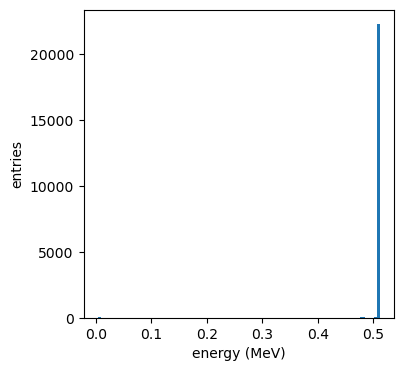

In [108]:
b, e = histoplot(df1c.e, 'energy (MeV)', "entries", bins=100, figsize=(4,4))

In [111]:
def plotd1c(bins=100, figsize=(8,8)):
    fig, ax = plt.subplots(2, 2, figsize=figsize)
    _ = ax[0,0].hist(df1c.x,bins)
    ax[0,0].set_xlabel("x (mm)")
    ax[0,0].set_ylabel("entries")
    #ax[0,0].set_title("x")
    _ = ax[0,1].hist(df1c.y,bins)
    ax[0,1].set_xlabel("y (mm)")
    ax[0,1].set_ylabel("entries")
    _ = ax[1,0].hist(df1c.z,bins)
    ax[1,0].set_xlabel("z (mm)")
    ax[1,0].set_ylabel("entries")
    _ = ax[1,1].hist(df1c.t,bins)
    ax[1,1].set_xlabel("t (ns)")
    ax[1,1].set_ylabel("entries")
    
    fig.tight_layout()
    plt.show()

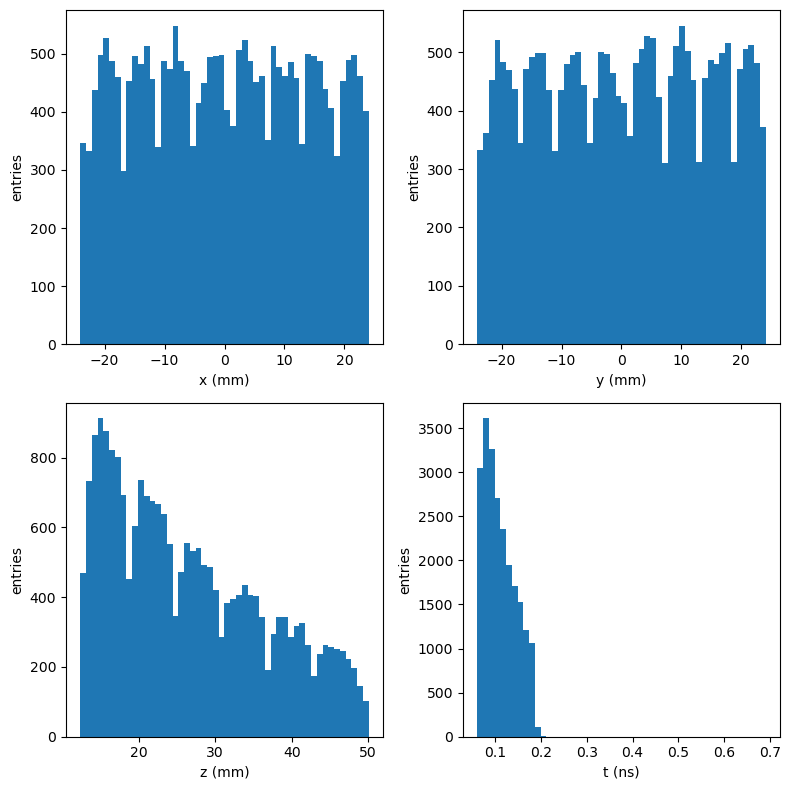

In [113]:
plotd1c(bins=50, figsize=(8,8))

Text(0, 0.5, 'e2 (mm)')

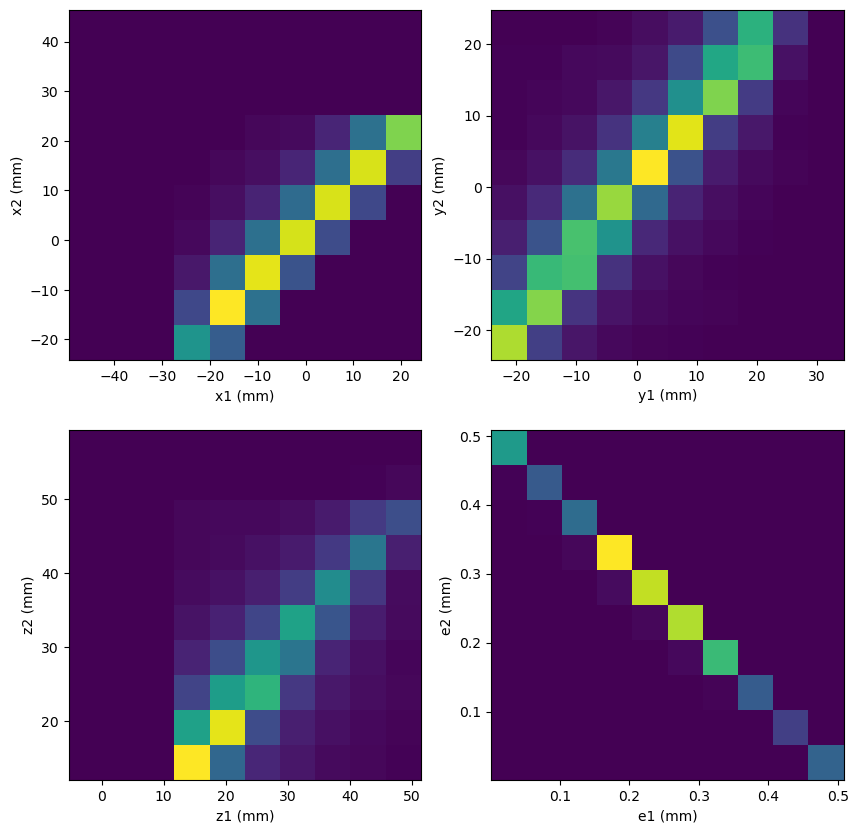

In [115]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))

hxy =ax[0,0].hist2d(df2c.x1, df2c.x2, cmap="viridis",bins=10)
#ax[0].set_aspect('equal')
ax[0,0].set_xlabel('x1 (mm)')
ax[0,0].set_ylabel('x2 (mm)')

hxz =ax[0,1].hist2d(df2c.y1, df2c.y2, cmap="viridis",bins=10)
#ax[1].set_aspect('equal')
ax[0,1].set_xlabel('y1 (mm)')
ax[0,1].set_ylabel('y2 (mm)')

hxz =ax[1,0].hist2d(df2c.z1, df2c.z2, cmap="viridis",bins=10)
#ax[1].set_aspect('equal')
ax[1,0].set_xlabel('z1 (mm)')
ax[1,0].set_ylabel('z2 (mm)')

hxz =ax[1,1].hist2d(df2c.e1, df2c.e2, cmap="viridis",bins=10)
#ax[1].set_aspect('equal')
ax[1,1].set_xlabel('e1 (mm)')
ax[1,1].set_ylabel('e2 (mm)')